# 🍿 Final Project - The Movie Database

For this project, we have targeted movies to analyze them and predict:
- A budget a movie must be allocated, to achieve a certain amount of revenue, public appreciation and popularity (Numerical);
- The single or multiple genres of a movie, by providing its text overview (Textual).

TODOs:
- TODO: describe the needs (why do the predictions)
- TODO: more models 
- TODO: comparison of the models with visualization 
- TODO: conclusion - business recommendations 

Imports we will be using for the project

In [52]:
import requests
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report

import re
import spacy
import spacy.cli

In [75]:
# Download the English language model, that includes tokenization, part-of-speech tagging, and lemmatization
spacy.cli.download("en_core_web_lg")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 38.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
API_KEY=""

## How did we collect the data?
> The Movie Database (TMDB) is a public API which provides lot of data about movies, series and TV Show including descriptions, title, ratings, and more.

We need to get the IDs of the movies we'd like to collect. TMDB uses a system of pages, where each page contains a list of movies

In [3]:
def get_full_array(page):
    try:
        url = f"https://api.themoviedb.org/3/discover/movie?page={page}"
        headers = {
            "accept": "application/json",
            "Authorization": f"Bearer {API_KEY}"
        }

        response = requests.get(url, headers=headers).text
        data = json.loads(response)
        return [movie['id'] for movie in data['results']]
    except Exception as e:
        return []

IDs = []
for page in tqdm(range(1, 700)):
    IDs += get_full_array(page)



100%|██████████| 699/699 [00:00<00:00, 1456442.37it/s]


In [4]:
IDs # List of movie IDs

[]

Since we have collected the movies's ID, we can now get the detail of each one

In [5]:
data = []
for id in tqdm(range(len(IDs))):
    id = IDs[id]
    url = f"https://api.themoviedb.org/3/movie/{id}"
    headers = {
        "accept": "application/json",
        "Authorization": f"Bearer {API_KEY}"
    }
    response = requests.get(url, headers=headers).text
    movie = json.loads(response)
    data.append(movie)

0it [00:00, ?it/s]


We convert the array into `Pandas` dataframe

In [6]:
df = pd.DataFrame(data)
pd.set_option('display.max_columns', None) # To display all columns
df.to_pickle("all_data.pkl") # Save DataFrame to a pickle file (To directly use the DataFrame later, instead of re-fetching)
df

""


## Preprocessing data

### Importing and filtering data 

In case we already have fetched the data, we can load the dataframe using the following command.

In [17]:
df = pd.read_pickle("all_data.pkl")

Since the project is based on French datas, we filter the movies by their `original_language` attribute

In [16]:
copy_df = df.copy()
fr_data = copy_df[copy_df['original_language'] == "fr"]
fr_data

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,origin_country,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
50,False,/4A5HH9HkCPqAwyYL6CnA0mxbYjn.jpg,"{'id': 1002775, 'name': 'Lost Bullet Collectio...",0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",https://www.netflix.com/title/81701729,1144430,tt29768333,[FR],fr,Balle perdue 3,Car genius Lino returns to conclude his vendet...,80.3702,/qycPITRqXgPai7zj1gKffjCdSB5.jpg,"[{'id': 134188, 'logo_path': '/ueed3yKbzBRB4hB...","[{'iso_3166_1': 'BE', 'name': 'Belgium'}, {'is...",2025-05-06,0,111,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,,Last Bullet,False,6.648,165
64,False,/bIh56F8e5EaZ3r2nD1hXAOisItZ.jpg,None,0,"[{'id': 12, 'name': 'Adventure'}, {'id': 10751...",https://www.gedeonmediagroup.com/en/production...,1094473,tt32373637,[FR],fr,"Bambi, l'histoire d'une vie dans les bois","The life of Bambi, a male roe deer, from his b...",66.5891,/vWNVHtwOhcoOEUSrY1iHRGbgH8O.jpg,"[{'id': 2668, 'logo_path': '/wXmehIpEfAaJk7eU6...","[{'iso_3166_1': 'FR', 'name': 'France'}]",2024-10-16,1419154,77,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,,Bambi: A Life in the Woods,False,6.042,24
90,False,/lS49jyUZg9xHfelHMsmL3o3H6rq.jpg,None,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",,1112466,tt27721737,[FR],fr,Les femmes au balcon,As a heat wave brings a Marseille neighbourhoo...,49.0230,/rEgAdJtf8S8JgUG2NJoWiRvpTz.jpg,"[{'id': 57752, 'logo_path': '/2k3j1B8TEbZPQgck...","[{'iso_3166_1': 'FR', 'name': 'France'}]",2024-11-15,0,105,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,,The Balconettes,False,6.438,56
99,False,/jzo95EcgXHcVrJQFDqoLSf3TJSF.jpg,None,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",,1318856,tt36462054,[FR],fr,Un Mariage sans fin,When carefree Paul and reluctant maid of honor...,44.9027,/uvygZlicNXBIpklnLuAbgwkMMSL.jpg,"[{'id': 234308, 'logo_path': None, 'name': 'Su...","[{'iso_3166_1': 'FR', 'name': 'France'}]",2025-05-30,0,81,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,,The Neverending Wedding,False,4.500,17
111,False,/1AWjIUgbZYaKbwUH5qoJaKCcRkf.jpg,None,0,"[{'id': 99, 'name': 'Documentary'}]",https://www.unity-house.co/van-gogh-by-vincent,1471014,tt36364552,[US],fr,Van Gogh by Vincent,"In a career that lasted only ten years, Vincen...",40.0709,/z73X4WKZghBh5fri31o8P6vBEB2.jpg,"[{'id': 134080, 'logo_path': None, 'name': 'Un...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",2025-03-26,0,46,[],Released,,Van Gogh by Vincent,False,5.941,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9796,False,/uLg9t6c34soxT4UAebbL3Cnlbl5.jpg,None,25000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",,77459,tt0961097,[FR],fr,Un monstre à Paris,"Paris, 1910. Emile, a shy movie projectionist,...",2.5082,/wSYZR2QL58jWPIEe9TG7G9PlTya.jpg,"[{'id': 6896, 'logo_path': '/2Q89KvzxTKB5BAv9R...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",2011-10-12,26611650,90,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,You can find love anywhere… even in insects,A Monster in Paris,False,6.900,1281
9813,False,/cHpBJ6EhBj2ZVCvMIsd8RJuoIjU.jpg,None,5133623,"[{'id': 35, 'name': 'Comedy'}]",,761,tt0074103,[FR],fr,L'Aile ou la Cuisse,"Charles Duchemin, a well-known gourmet and pub...",2.4804,/ywkIu5l3iAgPZvLFEVBDYxLouH8.jpg,"[{'id': 461, 'logo_path': '/reM5HtbhqjZnefmDST...","[{'iso_3166_1': 'FR', 'name': 'France'}]",1976-10-27,0,104,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,,The Wing or the Thigh?,False,7.213,902
9899,False,/8Df8Wsstu76Wr8cTPfNHrSveVe6.jpg,None,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",,869617,tt14700948,[FR],fr,Friendzone,Hopeful romantic Thibault believes his luck co...,1.4882,/xgQ55Koxnq6rwLoPDIfaIjm16bA.jpg,"[{'id'

Let's show the plots related to the collected data

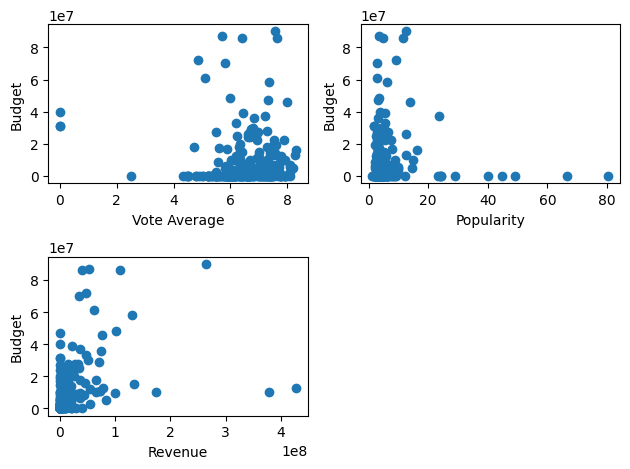

In [18]:
fig, ax = plt.subplots(2,2)

ax[0][0].scatter(fr_data['vote_average'], fr_data['budget'])
ax[0][0].set_xlabel('Vote Average')
ax[0][0].set_ylabel('Budget')

ax[0][1].scatter(fr_data['popularity'], fr_data['budget'])
ax[0][1].set_xlabel('Popularity')
ax[0][1].set_ylabel('Budget')

ax[1][0].scatter(fr_data['revenue'], fr_data['budget'])
ax[1][0].set_xlabel('Revenue')
ax[1][0].set_ylabel('Budget')

ax[1][1].axis('off')

plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()

### Numerical values

For the numerical values, we remove null values. Then, we split the dataset into train & test datasets.

Finally, we normalize the X train dataset, and we use the obtained values of the normalization for the X test dataset.  
We do not need to normalize the y datasets, because they are predicted. 

We also do not filter out the extreme values (outliers), because they are relevant in our study.

In [ ]:
filtered_num_df = fr_data[(fr_data['revenue'] > 0) & (fr_data['budget'] > 0)] # Some movies do not have revenue or budget data
numerical_num_df = filtered_num_df[["budget", "vote_average", "revenue", "popularity"]] # Extracting numerical columns

X = numerical_num_df[['revenue', 'vote_average', 'popularity']]
y = numerical_num_df['budget']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_scaler = StandardScaler()
X_train_scaled = num_scaler.fit_transform(X_train)
X_test_scaled = num_scaler.transform(X_test)

X_train_scaled

array([[-5.98495377e-01, -1.19383347e+00, -6.31853646e-01],
       [-3.93270010e-01,  1.61621490e+00,  5.37144113e-01],
       [-5.98538345e-01, -8.73051693e-01, -5.65131059e-01],
       [-3.32595953e-01,  8.73426876e-01, -7.44270901e-01],
       [ 3.58779047e-01, -3.32712609e-01,  2.84809926e-02],
       [-3.99085192e-01,  6.23929938e-01, -1.59643213e-01],
       [ 1.75612622e+00,  1.36956936e+00,  1.25714910e+00],
       [-5.62080768e-01, -9.04417022e-01, -2.37958528e-01],
       [ 1.09147690e-01, -1.78549764e+00, -5.06555583e-01],
       [-5.88872889e-01, -1.20238765e+00, -8.52887469e-02],
       [-4.97608348e-01,  6.22504241e-01, -4.51264713e-01],
       [-1.17733694e-01,  7.80756585e-01,  8.43900563e-01],
       [ 4.64465761e-01,  1.16712042e+00, -8.48186822e-01],
       [ 5.17989203e+00,  1.88139451e+00,  2.44318172e+00],
       [-4.24436007e-01, -1.33565278e-02, -6.69723223e-01],
       [-2.57140350e-01,  8.39210153e-01, -6.23738737e-01],
       [-5.32839475e-01,  2.00497991e-01

### Textual values

For the textual part, we have analyzed it as a multi-labelling problem, which means that a movie's overview can belong to several `genres`.  
This is a multi-label problem, because a movie can be associated with multiple genres. 

Furthermore, we will preprocess the text: convert the text to lowercase, remove punctuation and lemmatize the words.  
We can preprocess before the train & test split, because there is no risk of data leakage.  

In [ ]:
# Join the genre labels into a single string for each movie
df_text = fr_data[['overview', 'genres']]
df_text.loc[:, 'genres'] = df_text['genres'].apply(lambda x: ','.join([i['name'] for i in x]))

# Preprocess the overview text
nlp = spacy.load("en_core_web_lg")
with nlp.select_pipes(disable=[]):  # We use the parser component (syntaxic analysis), tokenization (text -> list), lemmatization (word to most basic form) and NER (unlinkable words) 
    preprocessed_texts = []
    for (i, doc) in enumerate(nlp.pipe(df_text["overview"], batch_size=50, n_process=-1)):
        # Exclude tokens that are part of a named entity (NER), punctuation, and stop words
        preprocessed_texts.append(' '.join([token.lemma_ for token in doc if not token.ent_type_ and not token.is_punct and not token.is_stop]))
    df_text.loc[:, "overview"] = preprocessed_texts
    
df_text

,overview,genres
50,car genius return conclude vendetta corrupt co...,"Action,Crime,Thriller,Drama"
64,life male roe deer birth childhood loss mother...,"Adventure,Family,Documentary"
90,heat wave bring neighbourhood boil roommate gl...,"Comedy,Horror,Fantasy"
99,carefree reluctant maid honor chance encounter...,"Comedy,Romance,Fantasy"
111,career last paint subject story tell iconic se...,Documentary
...,...,...
9796,shy movie projectionist colourful inventor fin...,"Adventure,Animation,Comedy,Family,Fantasy"
9813,know gourmet publisher famous restaurant guide...,Comedy
9899,hopeful romantic believe luck change spark fly...,"Romance,Comedy"
9918,billionaire tired whim child decide teach less...,Comedy


## Implementation of models

### Numerical values 

For the numerical values, we are going to use a Logistic Regression

In [ ]:
tfidf_model = LinearRegression()
tfidf_model.fit(X_train, y_train)

y_pred = tfidf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R² Score:", r2)

# TODO: use other models 

Mean Squared Error: 554258354793714.2
R² Score: 0.2522665155631386


### Textual values

For the classification, the model needs all the target possibilities. Therefore, we will list all the movie genres into one place. 

Classes are the possible categories of the dataset.  
Labels are the actual categories assigned to the data samples. 

In [77]:
all_genres_set = set()
for genres in df_text['genres']:
    all_genres_set.update(genres.split(','))
all_genres: list[str] = sorted(list(all_genres_set))
all_genres

['',
 'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War']

We will train the models with multi-label binarizer, as the teacher recommended. 

It transforms the labels into numbers. 

In [78]:
mlb = MultiLabelBinarizer(classes=all_genres)
df_text.loc[:, 'genres_list'] = df_text['genres'].apply(lambda x: x.split(','))
y = mlb.fit_transform(df_text['genres_list']) # We embed the target

X_train, X_test, y_train, y_test = train_test_split(
    df_text['overview'],
    y,
    test_size=0.2,
    random_state=42
)

X_train


/tmp/ipykernel_1150/21319872.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text.loc[:, 'genres_list'] = df_text['genres'].apply(lambda x: x.split(','))


1806    investigate judge grapple paranoia amid politi...
6272    mad woman tidy perfectionist thing common extr...
3729    extradite stand trial notorious criminal entru...
2532    small time delinquent turn police mechanic fas...
8809    God live God coward morally pathetic odious fa...
                              ...                        
4904    pornography boxing rock’n’roll live legend mot...
575     target sinister plot arrest wedding day crime ...
4373    fiancée dump altar ex young man leave alternat...
7562              faithful retelling d'hiv event surround
4696    having clear genius mechanic goal mind get rev...
Name: overview, Length: 204, dtype: object

Vectorizing the text with TF-IDF, which was the best vectorizer in the second lab 

In [79]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_text = tfidf_vectorizer.fit_transform(X_train)

X_train_text.toarray()[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

We will use OneVsRestClassifier to solve our multi-label classification problem.  
This works by training 1 classifier per class which learns to distinguish this class versus all others; and for prediction, for each class, the classifier with the highest score is chosen. 

In [80]:
tfidf_model = OneVsRestClassifier(LogisticRegression())
tfidf_model.fit(X_train_text, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

After fitting the One Vs. Rest classifier, we now can estimate its effectiveness with the test dataset. 

In [81]:
# TODO: fix the model only predicting drama 
y_pred = tfidf_model.predict(tfidf_vectorizer.transform(X_test))
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

                 precision    recall  f1-score   support

                      0.00      0.00      0.00         0
         Action       0.00      0.00      0.00        14
      Adventure       0.00      0.00      0.00         9
      Animation       0.00      0.00      0.00         6
         Comedy       0.00      0.00      0.00        15
          Crime       0.00      0.00      0.00         7
    Documentary       0.00      0.00      0.00         1
          Drama       0.55      0.96      0.70        25
         Family       0.00      0.00      0.00         6
        Fantasy       0.00      0.00      0.00         9
        History       0.00      0.00      0.00         2
         Horror       0.00      0.00      0.00         5
          Music       0.00      0.00      0.00         1
        Mystery       0.00      0.00      0.00         4
        Romance       0.00      0.00      0.00        10
Science Fiction       0.00      0.00      0.00         2
       TV Movie       0.00    

/home/wsl/ml/machine-learning-efrei-s8/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wsl/ml/machine-learning-efrei-s8/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wsl/ml/machine-learning-efrei-s8/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

Example

In [83]:
new_overview = pd.DataFrame(["A futuristic city where a detective must solve a series of crimes using advanced technology.",])

# Preprocess the overview text:
nlp = spacy.load("en_core_web_lg")
with nlp.select_pipes(disable=[]):  # We use the parser component (syntaxic analysis), tokenization (text -> list), lemmatization (word to most basic form) and NER (unlinkable words) 
    preprocessed_texts = []
    for (i, doc) in enumerate(nlp.pipe(new_overview[0], batch_size=50, n_process=-1)):
        preprocessed_texts.append(' '.join([token.lemma_ for token in doc if not token.ent_type_ and not token.is_punct and not token.is_stop]))
    new_overview.loc[:"0"] = preprocessed_texts

X_new = tfidf_vectorizer.transform(new_overview[0])
y_new = tfidf_model.predict(X_new)
predicted_genres = mlb.inverse_transform(y_new)
print("Predicted genres:", predicted_genres)

Predicted genres: [('Drama',)]
